# ARIMA Model

## 1. Import libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 2. Đọc Dataset và chia data thành 2 bộ train và test

In [2]:
# Đọc dữ liệu từ file CSV, lấy các cột cần thiết và phân tích cột 'Date' làm chỉ mục
df = pd.read_csv('./Data/Gold_Futures_Cleaned.csv', usecols=['Date', 'Price', 'Open', 'High', 'Low', 'Vol.'])
# df.sort_values(by='Date', ascending=True, inplace=True)
# df.reset_index(inplace=True)

# Đặt cột Date làm index (tùy thuộc vào nhu cầu)
df['Date'] = pd.to_datetime(df['Date'])     # Chuyển sang datetime
df.set_index('Date', inplace=True) 

# Loại bỏ các dòng có giá trị thiếu (NaN) trong dữ liệu
df = df.dropna()

# Tách dữ liệu thành train_data và test_data theo tỉ lệ 80:20
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# In kích thước của tập dữ liệu huấn luyện
print('Shape of data train', train_data.shape)

# In kích thước của tập dữ liệu kiểm tra
print('Shape of data test', test_data.shape)

# Tách biến mục tiêu 'Price' từ tập dữy_train = train_data['Price']
y_train = train_data['Price']
y_test = test_data['Price']

# Đầu vào (features) từ tập dữ liệu huấn luyện, loại bỏ cột 'Price', 'Vol.'
X_train = train_data.drop(columns=['Price', 'Vol.'])
X_test = test_data.drop(columns=['Price', 'Vol.'])


Shape of data train (3132, 5)
Shape of data test (783, 5)


In [3]:
print(df.head())

             Price    Open    High     Low      Vol.
Date                                                
2010-01-04  1118.3  1099.0  1124.6  1093.8  155480.0
2010-01-05  1118.7  1122.0  1129.6  1115.5  156410.0
2010-01-06  1136.5  1118.5  1141.0  1116.8  176900.0
2010-01-07  1133.7  1139.0  1139.5  1128.7  121150.0
2010-01-08  1138.9  1131.5  1140.0  1119.5  212620.0


## 3. Dataset overview

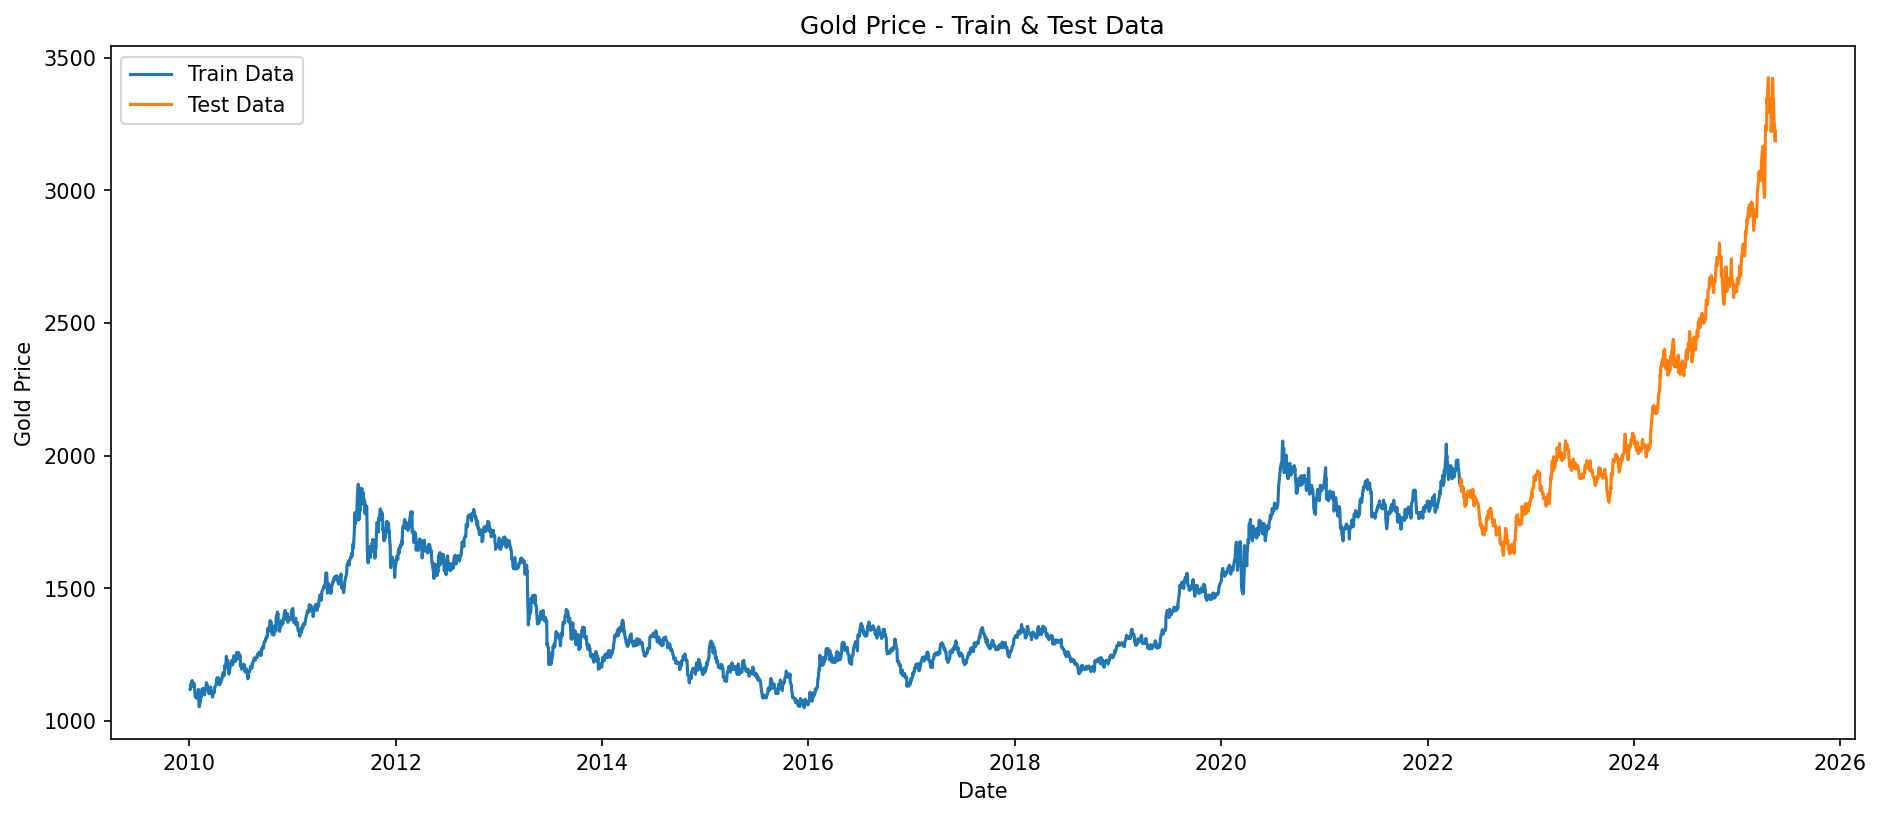

In [4]:
# Thiết lập kích thước biểu đồ với chiều rộng full (ví dụ 15 inch)
plt.figure(figsize=(15, 6), dpi=150)

# Vẽ biểu đồ cho tập huấn luyện (train)
plt.plot(train_data['Price'], label='Train Data')

# Vẽ biểu đồ cho tập kiểm tra (test)
plt.plot(test_data['Price'], label='Test Data')

# Thêm tiêu đề và nhãn
plt.title('Gold Price - Train & Test Data')
plt.xlabel('Date')
plt.ylabel('Gold Price')

# Chú thích
plt.legend()

# Hiển thị biểu đồ
plt.grid(color='white')
plt.show()

## 4. Thông tin chi tiết của tập Train và Test

In [5]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3132 entries, 2010-01-04 to 2022-04-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   3132 non-null   float64
 1   Open    3132 non-null   float64
 2   High    3132 non-null   float64
 3   Low     3132 non-null   float64
 4   Vol.    3132 non-null   float64
dtypes: float64(5)
memory usage: 146.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 783 entries, 2022-04-27 to 2025-05-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   783 non-null    float64
 1   Open    783 non-null    float64
 2   High    783 non-null    float64
 3   Low     783 non-null    float64
 4   Vol.    783 non-null    float64
dtypes: float64(5)
memory usage: 36.7 KB


### 5. Kiểm tra chuỗi thời gian có phải chuỗi dừng hay không

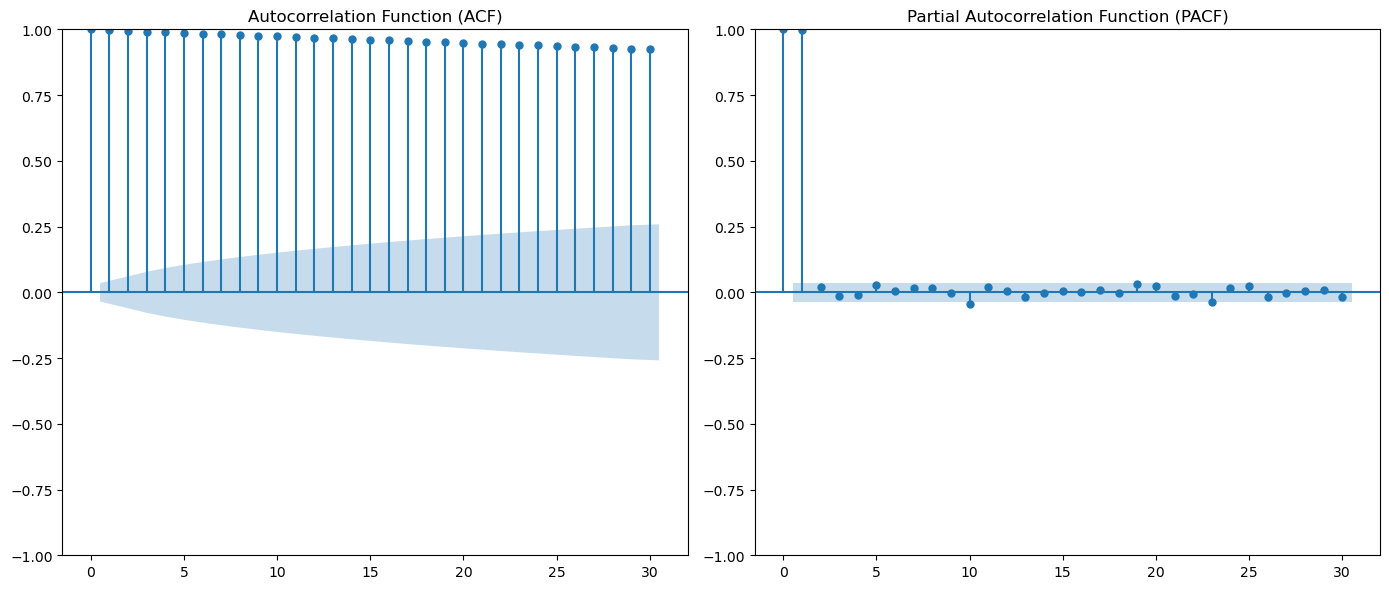

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Vẽ ACF và PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Vẽ ACF
plot_acf(y_train, lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# Vẽ PACF
plot_pacf(y_train, lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller
def check_adfuller(datasset):
  result = adfuller(datasset, autolag='AIC')
  print("1. ADF", result[0])
  print("2. P-Value: ", result[1])
  print("3. Num of Lags: ", result[2])
  print("4. Num of Observations Used for ADF Regression and Critical values calculation: ", result[3])
  print("5. Critical values: ")
  for key, val in result[4].items():
    print("\t", key, ": ", val)

In [8]:
check_adfuller(y_train)

1. ADF -1.2866592105665264
2. P-Value:  0.6352534257951592
3. Num of Lags:  9
4. Num of Observations Used for ADF Regression and Critical values calculation:  3122
5. Critical values: 
	 1% :  -3.4324463116051227
	 5% :  -2.8624662204644187
	 10% :  -2.567263049245277


**Giải thích kết quả:**

Kết quả kiểm định Dickey-Fuller tăng cường (ADF) cho chuỗi thời gian giá vàng cho thấy:
1.   Giá trị thống kê ADF (-1.70575) không đủ âm để bác bỏ giả thuyết null về sự tồn tại của gốc đơn vị, cho thấy chuỗi có khả năng không dừng.
2.   P-Value (0.4281) cao hơn mức ngưỡng thông thường (0.05), không đủ để bác bỏ giả thuyết null, hỗ trợ kết luận chuỗi không dừng.
3.   Số độ trễ là 1 và số lượng quan sát là 1830 được sử dụng trong phân tích.
4.   Các giá trị tới hạn cho 1%, 5%, và 10% đều nhỏ hơn giá trị thống kê ADF, củng cố thêm bằng chứng rằng chuỗi không dừng.

**Kết luận:** Chuỗi thời gian giá vàng không dừng. Cần biến đổi chuỗi (ví dụ: lấy sai phân) trước khi áp dụng mô hình dự báo như ARIMA.

In [9]:
y_train_diff = y_train.diff().dropna()

# Hiển thị vài dòng đầu của chuỗi đã biến đổi
print(y_train_diff.head())

# Kiểm tra tính dừng của chuỗi đã biến đổi
check_adfuller(y_train_diff)

Date
2010-01-05     0.4
2010-01-06    17.8
2010-01-07    -2.8
2010-01-08     5.2
2010-01-11    12.5
Name: Price, dtype: float64
1. ADF -18.777383509805777
2. P-Value:  2.024573766469473e-30
3. Num of Lags:  8
4. Num of Observations Used for ADF Regression and Critical values calculation:  3122
5. Critical values: 
	 1% :  -3.4324463116051227
	 5% :  -2.8624662204644187
	 10% :  -2.567263049245277


**Giải thích kết quả:**

Kết quả kiểm định Dickey-Fuller tăng cường (ADF) cho chuỗi thời gian giá vàng cho thấy:
1.   Giá trị thống kê ADF (-44.50652871715483) rất âm và thấp hơn các giá trị tới hạn cho mọi mức ý nghĩa thống kê (1%, 5%, 10%), cho thấy chuỗi đã dừng.
2.   P-Value (0.0) rất nhỏ, cung cấp bằng chứng mạnh mẽ để bác bỏ giả thuyết null, khẳng định chuỗi đã dừng.
3.   Số độ trễ là 0 và số lượng quan sát là 1830 được sử dụng trong phân tích.

**Kết luận:** Chuỗi sai phân đã dừng, cho phép tiếp tục mô hình hóa và dự báo sử dụng mô hình ARIMA hoặc các mô hình chuỗi thời gian khác. Chuỗi đã dừng là điều kiện cần thiết cho việc mô hình hóa chuỗi thời gian hiệu quả.

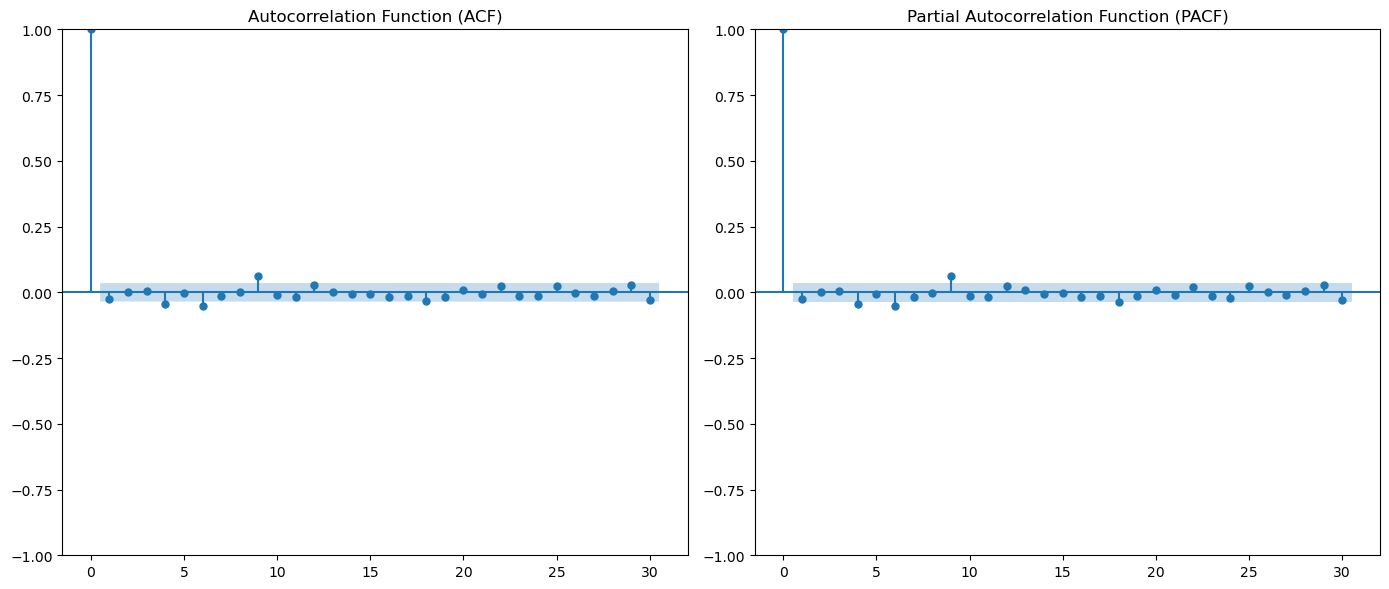

In [10]:
# Vẽ ACF và PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Vẽ ACF
plot_acf(y_train_diff, lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# Vẽ PACF
plot_pacf(y_train_diff, lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### 6. Chọn mô hình phù hợp nhất

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
stepwise_fit = auto_arima(y_train_diff, start_p=0, start_q=0,
                      test='adf',       # sử dụng ADF test để xác định d
                      max_p=5, max_q=5, # giới hạn tối đa cho p và q
                      d=None,           # để None nếu muốn tự động xác định d
                      seasonal=False,   # đặt True nếu chuỗi thời gian là mùa vụ
                      stepwise=True,    # sử dụng phương pháp stepwise để tìm mô hình tối ưu
                      information_criterion='aic',  # sử dụng AIC để tìm mô hình tốt nhất
                      trace=True,       # in ra các bước tìm kiếm
                      error_action='ignore',
                      suppress_warnings=True,
                      random_state=42)        # số lượng mô hình khác nhau để thử
stepwise_fit.summary()

c:\Users\vyvom\anaconda3\envs\datamining\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vyvom\anaconda3\envs\datamining\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vyvom\anaconda3\envs\datamining\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vyvom\anaconda3\envs\datamining\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vyvom\anaconda3\envs\datamining\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'e

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=25991.144, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=25990.905, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=25990.912, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=25992.900, Time=0.17 sec


c:\Users\vyvom\anaconda3\envs\datamining\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vyvom\anaconda3\envs\datamining\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=25992.903, Time=0.13 sec


c:\Users\vyvom\anaconda3\envs\datamining\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=25994.901, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=25992.028, Time=0.12 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.229 seconds


c:\Users\vyvom\anaconda3\envs\datamining\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3131
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -12993.453
Date:                Sat, 24 May 2025   AIC                          25990.905
Time:                        00:08:41   BIC                          26003.003
Sample:                             0   HQIC                         25995.247
                               - 3131                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0267      0.012     -2.173      0.030      -0.051      -0.003
sigma2       235.6407      2.918     80.741      0.000     229.921     241.361
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8418.12
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.82
Prob(H) (two-sided):                  0.01   Kurtosis:                        10.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 7. Khởi tạo và huấn luyện mô hình ARIMA

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Khởi tạo và train mô hình
model = ARIMA(y_train_diff, order=stepwise_fit.order)  # ARIMA(1,0,1)

fit_model = model.fit()

c:\Users\vyvom\anaconda3\envs\datamining\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\vyvom\anaconda3\envs\datamining\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\vyvom\anaconda3\envs\datamining\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### 7. Dự đoán và tính toán các độ đo

In [13]:
# Dự đoán
predictions_diff = fit_model.forecast(steps=test_data.shape[0])

# Khôi phục giá trị gốc từ sai phân (nếu đã thực hiện sai phân)
if adfuller(y_train)[1] > 0.05:
    predictions = y_train.iloc[-1] + predictions_diff.cumsum()
else:
    predictions = predictions_diff

y_true = y_test.values
y_pred = predictions  # Sử dụng giá trị đã được khôi phục từ sai phân

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100 

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# R-squared (R²)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

c:\Users\vyvom\anaconda3\envs\datamining\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\vyvom\anaconda3\envs\datamining\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


MAE: 278.9916614411422
MAPE: 11.20221408997925%
RMSE: 413.3387748449863
R²: 0.04817661794866712


### 8. Biểu đồ dự đoán của mô hình

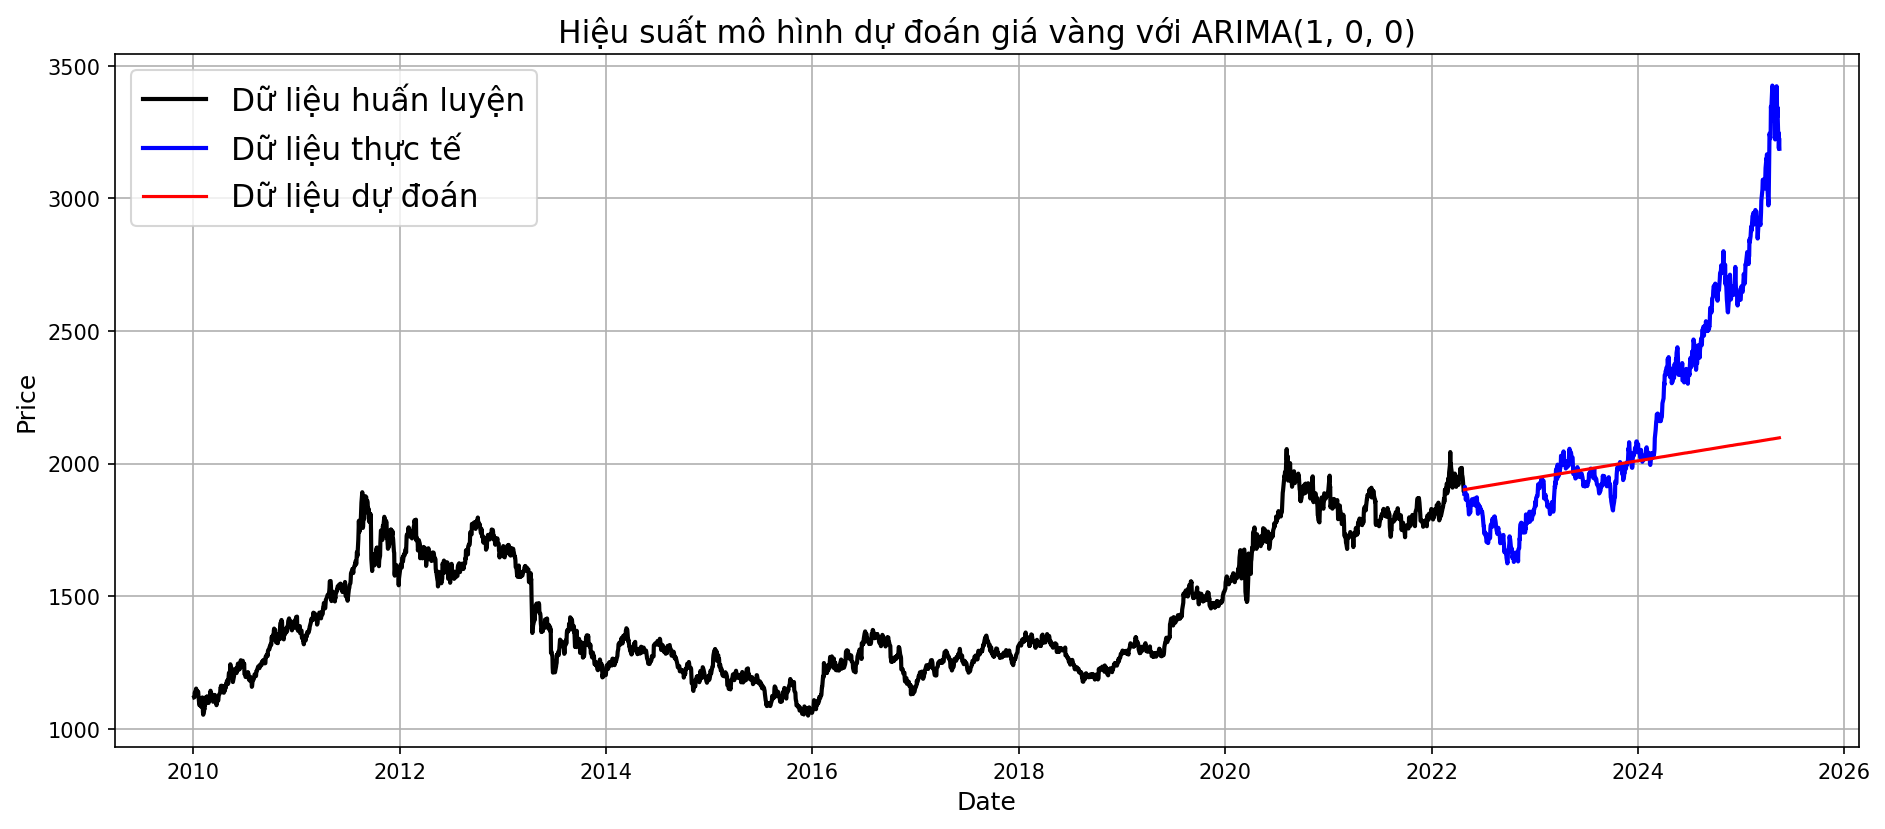

In [14]:
plt.figure(figsize=(15, 6), dpi=150)
plt.gca().set_facecolor('white')

# Vẽ dữ liệu huấn luyện
plt.plot(train_data.index, y_train.values, color='black', lw=2)

# Vẽ dữ liệu thực tế của tập kiểm tra
plt.plot(test_data.index, y_test, color='blue', lw=2)

# Vẽ dữ liệu dự đoán từ mô hình ARIMA
plt.plot(test_data.index, predictions, label='Dữ liệu dự đoán', color='red')

# Tiêu đề và nhãn
plt.title(f'Hiệu suất mô hình dự đoán giá vàng với ARIMA{stepwise_fit.order}', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Chú thích
plt.legend(['Dữ liệu huấn luyện', 'Dữ liệu thực tế', 'Dữ liệu dự đoán'], prop={'size': 15})
plt.grid(True)
plt.show()